### Importamos las librerías necesarias

In [1]:
import numpy as np
from pathlib import Path
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Input, Flatten, Activation, Dropout, BatchNormalization, ReLU, Add
from keras.layers import Dense, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomTranslation, RandomContrast
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from PIL import Image

### Configuramos la gpu

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

### Carga de datos

In [3]:
# Directorio de los datos
DATA_DIRECTORY_TRAIN = Path("TP1-3-natural-scenes/TP1-3-natural-scenes/seg_train/seg_train") 
DATA_DIRECTORY_TEST = Path("TP1-3-natural-scenes/TP1-3-natural-scenes/seg_test/seg_test") 

# Tamaño del lote (batch size)
BATCH_SIZE = 64

# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_TRAIN,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_TEST,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = True)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


## Análisis exploratorio

#### Inspeccionamos las clases

In [4]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


#### Observamos si el datset está balanceado

In [5]:
# Directorio de las imágenes de entrenamiento
TRAIN_IMAGES_DIRECTORY = Path("TP1-3-natural-scenes/TP1-3-natural-scenes/seg_train/seg_train")

# Diccionario para almacenar el conteo por clase
class_counts = {}

# Recorrer las carpetas dentro del directorio
for class_folder in TRAIN_IMAGES_DIRECTORY.iterdir():
    if class_folder.is_dir():
        class_name = class_folder.name
        num_images = len(list(class_folder.glob("*.jpg")))  # Contar las imágenes en la carpeta
        class_counts[class_name] = num_images

# Mostrar el conteo por clase
for class_name, count in class_counts.items():
    print(f"Clase: {class_name}, Número de imágenes: {count}")


Clase: buildings, Número de imágenes: 2191
Clase: forest, Número de imágenes: 2271
Clase: glacier, Número de imágenes: 2404
Clase: mountain, Número de imágenes: 2512
Clase: sea, Número de imágenes: 2274
Clase: street, Número de imágenes: 2382


#### Visualizamos algunas imágenes de ejemplo

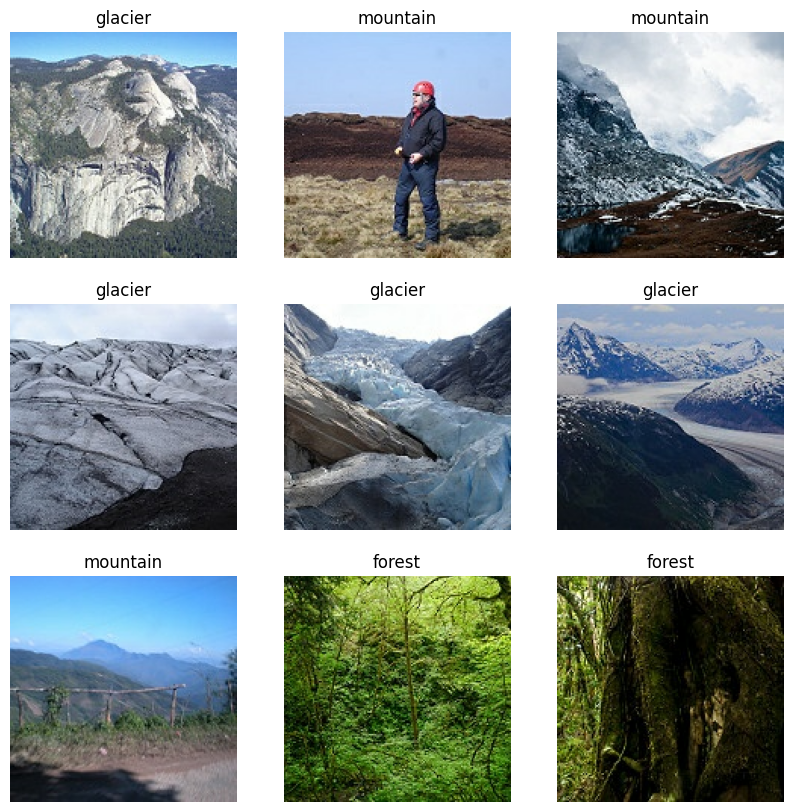

In [6]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

### División de los datos en X y en Y

In [7]:
# Función para dividir características (X) y etiquetas (y)
def split_features_labels(image, label):
    return image, label

# Dividiendo en X (imágenes) e y (etiquetas)
X_train, y_train = zip(*train_ds)
X_test, y_test = zip(*val_ds)

# Modelo con capas densas

### Definimos nuestro modelo utilizando Tensorflow

In [8]:
model_dense = Sequential([
    Flatten(input_shape=(150, 150, 3)),  
    Rescaling(1./255),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(6, activation="softmax"),  
])

c:\Users\Usuario\OneDrive\Documentos\PDI1\entorno_virtual\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Resumen del modelo

In [9]:
model_dense.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,652,934 (33.01 MB)

 Trainable params: 8,652,934 (33.01 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamos el modelo

In [10]:
# Compilación del modelo
model_dense.compile(optimizer="adam", 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento del modelo
history = model_dense.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 58s 233ms/step - accuracy: 0.3223 - loss: 3.1260 - val_accuracy: 0.4383 - val_loss: 1.4212
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 49s 221ms/step - accuracy: 0.4832 - loss: 1.3679 - val_accuracy: 0.4810 - val_loss: 1.3575
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 49s 222ms/step - accuracy: 0.5268 - loss: 1.2612 - val_accuracy: 0.5097 - val_loss: 1.2834
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 49s 222ms/step - accuracy: 0.5422 - loss: 1.2046 - val_accuracy: 0.4653 - val_loss: 1.3377
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 48s 220ms/step - accuracy: 0.5463 - loss: 1.1786 - val_accuracy: 0.5567 - val_loss: 1.2008
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 50s 226ms/step - accuracy: 0.5768 - loss: 1.1077 - val_accuracy: 0.5417 - val_loss: 1.2042
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 50s 228ms/step - accuracy: 0.5978 - loss: 1.0650 - val_accuracy: 0.5123 - val_loss: 1.3934
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 50s 227ms/step - accuracy: 0.5917 - loss: 1

### Evaluamos el modelo

In [11]:
# Evaluación en el conjunto de entrenamiento
train_loss, train_acc = model_dense.evaluate(train_ds)
print(f"Precisión en el conjunto de entrenamiento: {train_acc:.4f}")

# Evaluación en el conjunto de prueba
test_loss, test_acc = model_dense.evaluate(val_ds)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")


220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.6258 - loss: 0.9808
Precisión en el conjunto de entrenamiento: 0.6303
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5440 - loss: 1.2525
Precisión en el conjunto de prueba: 0.5463


### Gráfico del historial de métricas

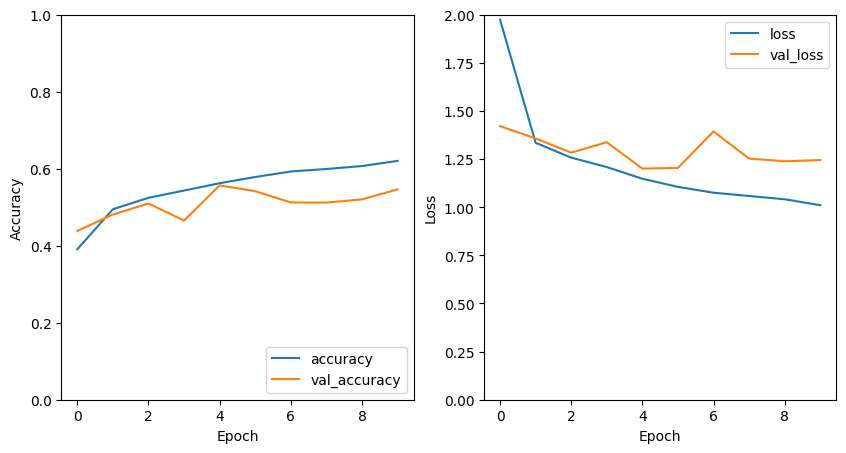

In [12]:
# Plot the training history, accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')

### Predecimos en nuevas imágenes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


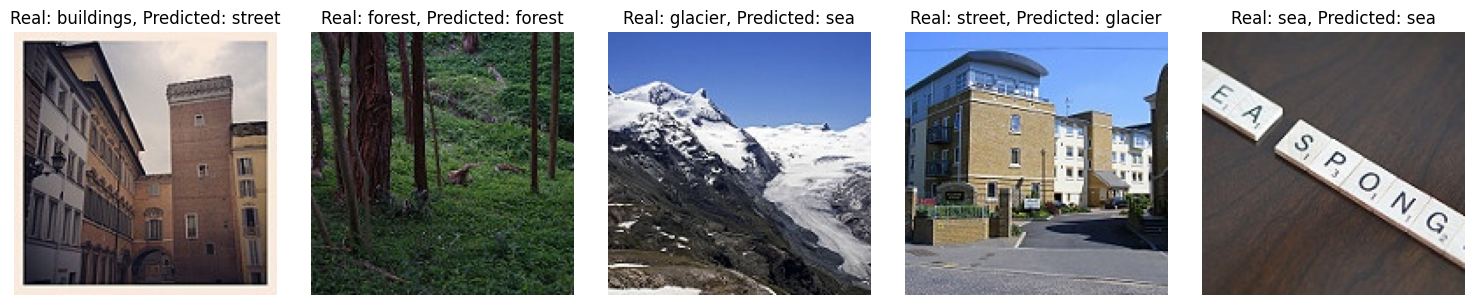

In [13]:
# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Directorio de las imágenes de test
TEST_IMAGES_DIRECTORY = Path("TP1-3-natural-scenes/TP1-3-natural-scenes/seg_test/seg_test")

# Clases (etiquetas) de las imágenes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Obtener la lista de imágenes y sus rutas con sus carpetas correspondientes (etiquetas)
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*/*.jpg"))

# Mezclar la lista de rutas de imágenes aleatoriamente
np.random.shuffle(test_image_paths)

# Mostrar 5 imágenes con su clase real y predicha
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  

    # Realizar la predicción
    prediction = model_dense.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Obtener la clase real a partir del nombre de la carpeta
    actual_class = image_path.parent.name

    # Mostrar el resultado
    ax.set_title(f"Real: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()


# Modelo con capas convolucionales y densas.

### Definimos la arquitectura de la red

In [14]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    # Normalizo las imágenes para que están en valores entro 0 y 1
    x = Rescaling(1./255)(i)
    
    # Data Aumentation
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

### Construimos el modelo

In [15]:
print("Building model")
model_dense_cnn = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), 6)

model_dense_cnn.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


### Resumen del modelo

In [16]:
model_dense_cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 146, 146, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 71, 71, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │        98,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,838 (479.84 KB)

 Trainable params: 122,838 (479.84 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamos el modelo

In [17]:
# Número de épocas de entrenamiento
EPOCHS = 10

# Entrena el modelo
history = model_dense_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 149s 662ms/step - accuracy: 0.4343 - loss: 1.3642 - val_accuracy: 0.6087 - val_loss: 0.9920
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 142s 646ms/step - accuracy: 0.6181 - loss: 0.9798 - val_accuracy: 0.6567 - val_loss: 0.9900
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 147s 669ms/step - accuracy: 0.6657 - loss: 0.8755 - val_accuracy: 0.7277 - val_loss: 0.7422
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 182s 827ms/step - accuracy: 0.6997 - loss: 0.8098 - val_accuracy: 0.7387 - val_loss: 0.7251
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 153s 695ms/step - accuracy: 0.7264 - loss: 0.7388 - val_accuracy: 0.7620 - val_loss: 0.6513
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 143s 649ms/step - accuracy: 0.7413 - loss: 0.6948 - val_accuracy: 0.7797 - val_loss: 0.6094
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 144s 653ms/step - accuracy: 0.7445 - loss: 0.6883 - val_accuracy: 0.7707 - val_loss: 0.6068
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 145s 658ms/step - accuracy: 0.7673 -

### Evaluamos el modelo

In [18]:
# Evaluación en el conjunto de entrenamiento
train_loss, train_acc = model_dense_cnn.evaluate(train_ds)
print(f"Precisión en el conjunto de entrenamiento: {train_acc:.4f}")

# Evaluación en el conjunto de prueba
test_loss, test_acc = model_dense_cnn.evaluate(val_ds)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")


220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.7980 - loss: 0.5626
Precisión en el conjunto de entrenamiento: 0.8006
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.7822 - loss: 0.5492
Precisión en el conjunto de prueba: 0.7813


### Visualizamos resultados

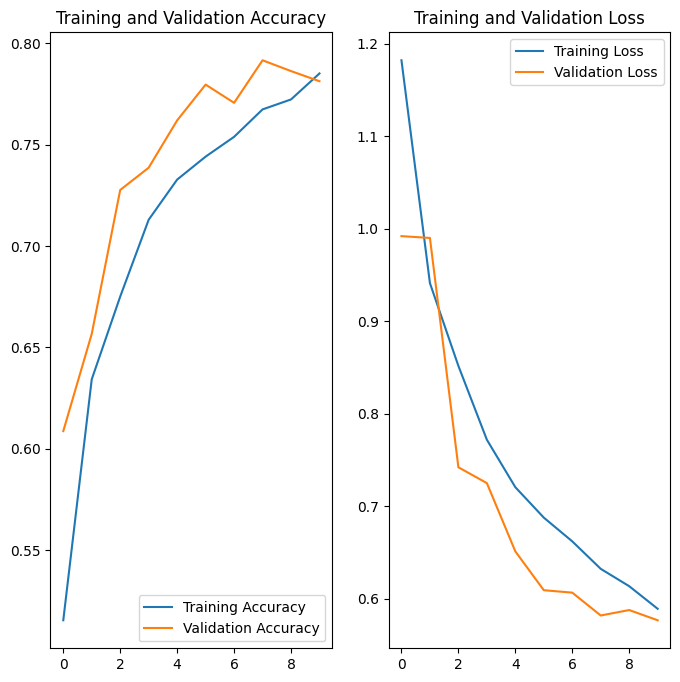

In [19]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predecimos en nuevas imágenes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


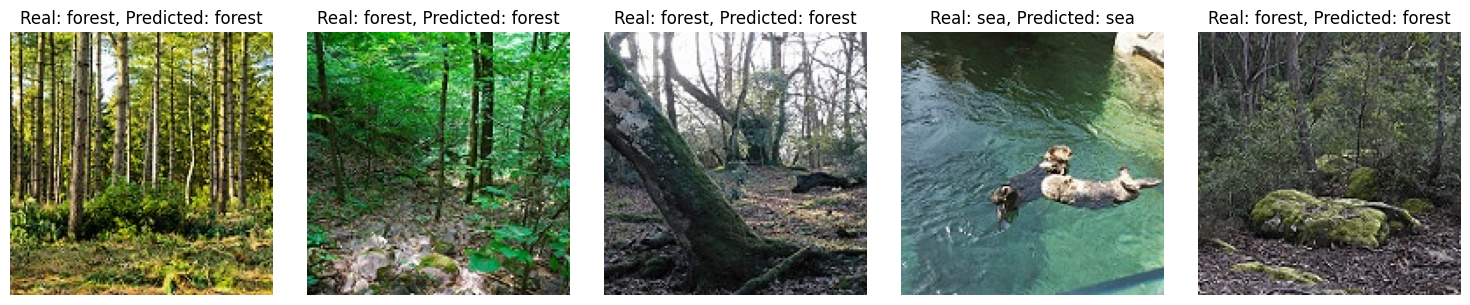

In [20]:
# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Directorio de las imágenes de test
TEST_IMAGES_DIRECTORY = Path("TP1-3-natural-scenes/TP1-3-natural-scenes/seg_test/seg_test")

# Clases (etiquetas) de las imágenes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Obtener la lista de imágenes y sus rutas con sus carpetas correspondientes (etiquetas)
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*/*.jpg"))

# Mezclar la lista de rutas de imágenes aleatoriamente
np.random.shuffle(test_image_paths)

# Mostrar 5 imágenes con su clase real y predicha
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  

    # Realizar la predicción
    prediction = model_dense_cnn.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Obtener la clase real a partir del nombre de la carpeta
    actual_class = image_path.parent.name

    # Mostrar el resultado
    ax.set_title(f"Real: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

# Modelo que incluya bloques residuales identidad
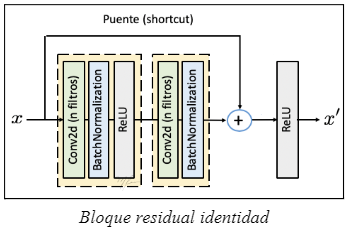


### Definimos nuestro bloque residual con la arquitectura planteada anteriormente

In [21]:
def residual_block(x, filters):
    # Primera capa de convolución + BatchNormalization + ReLU
    
    shortcut = x  # Puente (shortcut)
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Segunda capa de convolución + BatchNormalization
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Sumar el shortcut (conexión residual)
    x = Add()([x, shortcut])
    
    # Activación final
    x = ReLU()(x)
    
    return x

### Definimos una función para construie el modelo

In [22]:
def resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Rescaling(1./255)(inputs)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    # Bloques residuales
    x = residual_block(x, 64)
    x = residual_block(x, 64)
        
    # Clasificación final
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Uso del modelo
input_shape = (150, 150, 3)  
num_classes = 6  
model_resnet = resnet(input_shape, num_classes)

### Resumen del modelo

In [23]:
model_resnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 75, 75,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 75, 75,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 38, 38,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 38, 38,    │     36,928 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 38, 38,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 38, 38,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 38, 38,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 38, 38,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 38, 38,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 38, 38,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 38, 38,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        256 │ conv2d_8[0][0]  

 Total params: 23,818,758 (90.86 MB)

 Trainable params: 23,818,118 (90.86 MB)

 Non-trainable params: 640 (2.50 KB)

### Entrenamos el modelo

In [24]:
model_resnet.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 648s 3s/step - accuracy: 0.3955 - loss: 34.1484 - val_accuracy: 0.4527 - val_loss: 2.6172
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 627s 3s/step - accuracy: 0.5676 - loss: 1.9019 - val_accuracy: 0.5723 - val_loss: 1.4291
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 633s 3s/step - accuracy: 0.6433 - loss: 1.3227 - val_accuracy: 0.5360 - val_loss: 2.0345
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 624s 3s/step - accuracy: 0.6976 - loss: 1.0914 - val_accuracy: 0.6017 - val_loss: 1.4260
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 619s 3s/step - accuracy: 0.7495 - loss: 0.7984 - val_accuracy: 0.7203 - val_loss: 0.9054
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 627s 3s/step - accuracy: 0.8100 - loss: 0.5895 - val_accuracy: 0.6397 - val_loss: 1.2568
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 627s 3s/step - accuracy: 0.8120 - loss: 0.5697 - val_accuracy: 0.6993 - val_loss: 0.9482
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 608s 3s/step - accuracy: 0.8380 - loss: 0.4574 - val_acc

### Visualizamos los resultados

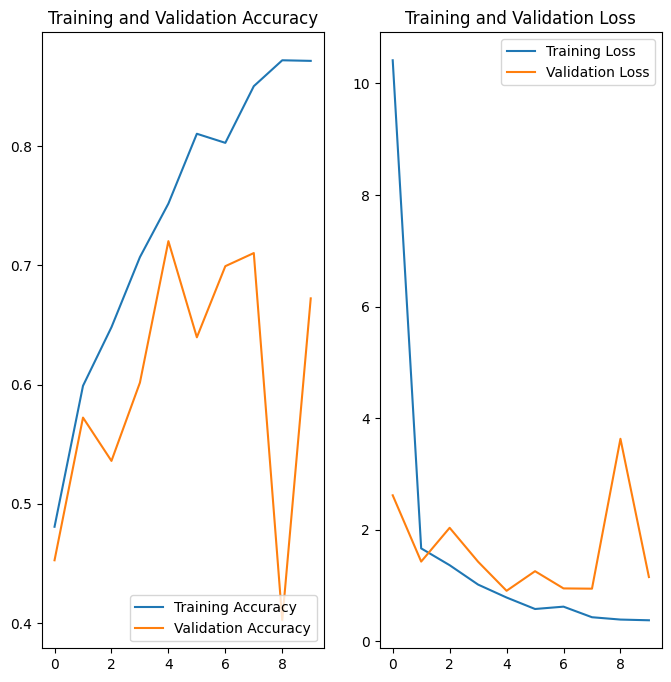

In [25]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predecimos en nuevas imágenes

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


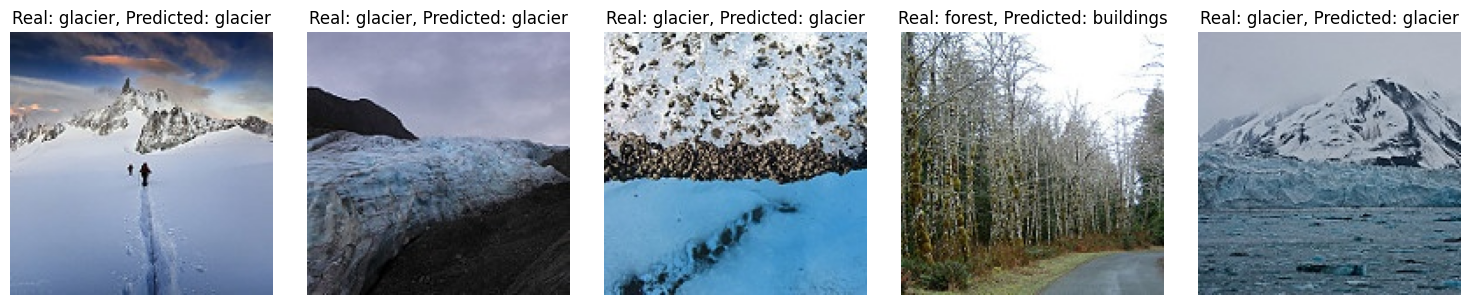

In [26]:
# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Directorio de las imágenes de test
TEST_IMAGES_DIRECTORY = Path("TP1-3-natural-scenes/TP1-3-natural-scenes/seg_test/seg_test")

# Clases (etiquetas) de las imágenes
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Obtener la lista de imágenes y sus rutas con sus carpetas correspondientes (etiquetas)
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*/*.jpg"))

# Mezclar la lista de rutas de imágenes aleatoriamente
np.random.shuffle(test_image_paths)

# Mostrar 5 imágenes con su clase real y predicha
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocesar la imagen
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  

    # Realizar la predicción
    prediction = model_resnet.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Obtener la clase real a partir del nombre de la carpeta
    actual_class = image_path.parent.name

    # Mostrar el resultado
    ax.set_title(f"Real: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()